# 1. Setup and Create Custom Dataset

In [1]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
import torch.optim as optim
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        self.images = sorted(os.listdir(image_folder))
        self.labels = sorted(file for file in os.listdir(label_folder) if file.endswith('.json'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])

        # Get the corresponding label file in the label folder
        label_file = self.labels[idx]
        label_path = os.path.join(self.label_folder, label_file)

        image = Image.open(img_path).convert("RGB")

        # Open and read the content of the label file
        with open(label_path, 'r') as f:
            # Load JSON content from the label file
            label_data = json.load(f)

        # Convert label data to tensor
        # Assuming your label_data contains 'class' and 'bboxes'
        label_tensor = torch.tensor([label_data['class']] + label_data['bbox'], dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(image_folder='aug_data/train/images', label_folder='aug_data/train/labels', transform=transform)
val_dataset = CustomDataset(image_folder='aug_data/val/images', label_folder='aug_data/val/labels/', transform=transform)

# 2- Create the CNN using Batch-Norm and Max-Pooling

In [2]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 5)  # Assuming 6 parameters for bounding box + class

    def forward(self, x):
        x = self.pool1(self.batch_norm1(nn.functional.relu(self.conv1(x))))
        x = self.pool2(self.batch_norm2(nn.functional.relu(self.conv2(x))))
        x = self.pool3(self.batch_norm3(nn.functional.relu(self.conv3(x))))
        x = self.pool4(self.batch_norm4(nn.functional.relu(self.conv4(x))))

        x = x.view(-1, 128 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = SimpleCNN()

# 3- Train the model

In [7]:
import torch.optim as optim

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


def train(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                epoch_val_loss += val_loss.item()

        # Average loss over all batches in an epoch
        epoch_train_loss /= len(train_loader)
        epoch_val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}')

        # Save losses for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

    return train_losses, val_losses
    
train_losses, val_losses = train(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0004)

model_path = 'Models/model2_CNN.pth'
torch.save(model.state_dict(), model_path)

Epoch 1/10, Train Loss: 0.556099874774615, Validation Loss: 0.2089042557137353
Epoch 2/10, Train Loss: 0.04454074203968048, Validation Loss: 0.08782887352364403
Epoch 3/10, Train Loss: 0.024220023521532616, Validation Loss: 0.03526979112731559
Epoch 4/10, Train Loss: 0.019024027138948442, Validation Loss: 0.03271140410963978
Epoch 5/10, Train Loss: 0.01612521338587006, Validation Loss: 0.03173493407666683
Epoch 6/10, Train Loss: 0.014133004564791917, Validation Loss: 0.03425062780401537
Epoch 7/10, Train Loss: 0.012361461094891031, Validation Loss: 0.02845363944236721
Epoch 8/10, Train Loss: 0.0111146855323265, Validation Loss: 0.027180961266692196
Epoch 9/10, Train Loss: 0.009639955125749111, Validation Loss: 0.02683801855891943
Epoch 10/10, Train Loss: 0.008910211090308925, Validation Loss: 0.02877607835190637


# 4- Plot the Training Loss x Validation Loss

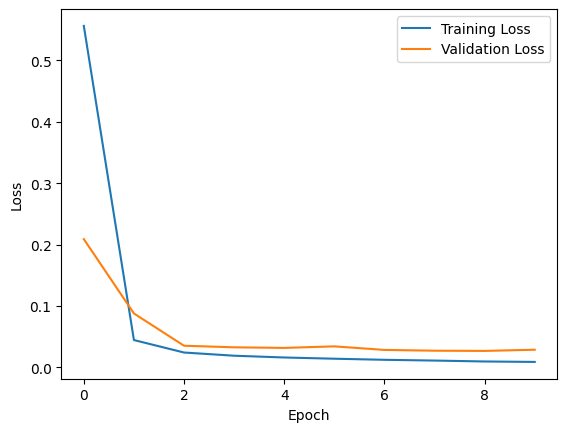

In [8]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses)

In [3]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('Models/model2_CNN.pth'))
model.eval()

def detect_face(frame, model):
    # Preprocess the frame
    img = cv2.resize(frame, (120, 120))
    img = Image.fromarray(img)  # Convert numpy array to PIL Image
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add any other necessary transformations
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Run the model
    with torch.no_grad():
        output = model(img)
        

    # Post-process the output (assuming bounding box coordinates and class)
    # Extract class and bounding box coordinates from the output tensor
    pred_class = int(output[0, 0])
    bbox = list(map(float, output[0, 1:].tolist()))
    print(pred_class)
    

    # Draw bounding box only if the predicted class is 0
    if pred_class == 0:
        print(f"Class: {pred_class}, Bbox: {bbox}")
    
        bbox = [int(coord * frame.shape[1]) for coord in bbox]  # Scale coordinates

        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    return frame

# Open a webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect face
    frame = detect_face(frame, model)

    # Display the resulting frame
    cv2.imshow('Face Detection', frame)

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

1
0
Class: 0, Bbox: [0.04219052195549011, 0.06632000207901001, 0.16605007648468018, 0.3067733645439148]
0
Class: 0, Bbox: [0.06758642196655273, 0.03604942187666893, 0.13524223864078522, 0.2634815275669098]
0
Class: 0, Bbox: [0.061579130589962006, 0.012553993612527847, 0.13571439683437347, 0.2637283504009247]
0
Class: 0, Bbox: [0.04934830963611603, 0.03369384631514549, 0.1370808482170105, 0.2753250300884247]
0
Class: 0, Bbox: [0.061300165951251984, 0.030053138732910156, 0.15861882269382477, 0.27121663093566895]
0
Class: 0, Bbox: [0.06935039907693863, 0.03545631095767021, 0.15596653521060944, 0.2803875505924225]
0
Class: 0, Bbox: [0.053327929228544235, 0.020345065742731094, 0.16678960621356964, 0.2955766022205353]
0
Class: 0, Bbox: [0.059897031635046005, 0.07602810859680176, 0.17604628205299377, 0.31372442841529846]
0
Class: 0, Bbox: [0.06843939423561096, 0.07364185154438019, 0.18698005378246307, 0.312949001789093]
0
Class: 0, Bbox: [0.06413096189498901, 0.09010306000709534, 0.1940790861